In [25]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pyvista as pv
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob

In [26]:
#DATASET_NAME = 'RF_FULGUR_MESH'
DATASET_NAME = 'RF_FULGUR_M_MESH'

PARTICLES_DIR = f'./OUTPUT/{DATASET_NAME}/{DATASET_NAME}_default_particles'
OUTPUT_DIR = f'./OUTPUT/{DATASET_NAME}/PCA_results'

In [27]:
def get_particles(particles_dir, type='local'):
    particles = []
    names = []
    for filename in os.listdir(particles_dir):
        if filename.endswith(type + ".particles"):
            filepath = os.path.join(particles_dir, filename)
            try:
                data = np.loadtxt(filepath)
                particles.append(data)
                names.append(os.path.splitext(filename)[0])  # Keep the file name without extension
            except Exception as e:
                print(f"Error reading file {filename}: {e}")
    if particles:
        return np.array(particles), names
    return None, None

# Exemple d'utilisation
particles, shape_names = get_particles(PARTICLES_DIR)
print(particles.shape)
#print(names)

(28, 128, 3)


In [28]:
pv.global_theme.jupyter_backend = None
pv.global_theme.notebook = False

def plot_particles_with_pyvista(particles, index=0):
    if index >= len(particles):
        print(f"Index {index} out of bounds for particles array of size {len(particles)}")
        return
    plotter = pv.Plotter(window_size=(800, 600))
    plotter.set_background("white")
    plotter.add_points(particles[index], color='red', point_size=5, render_points_as_spheres=True)
    plotter.show()

#plot_particles_with_pyvista(particles, index=0)

In [29]:
particles_flat = particles.reshape(particles.shape[0], -1)
print(particles_flat.shape)

pca = PCA(n_components=5)
components = pca.fit_transform(particles_flat)

None

(28, 384)


C:\Users\sacha\AppData\Local\Temp\ipykernel_19328\1978447161.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


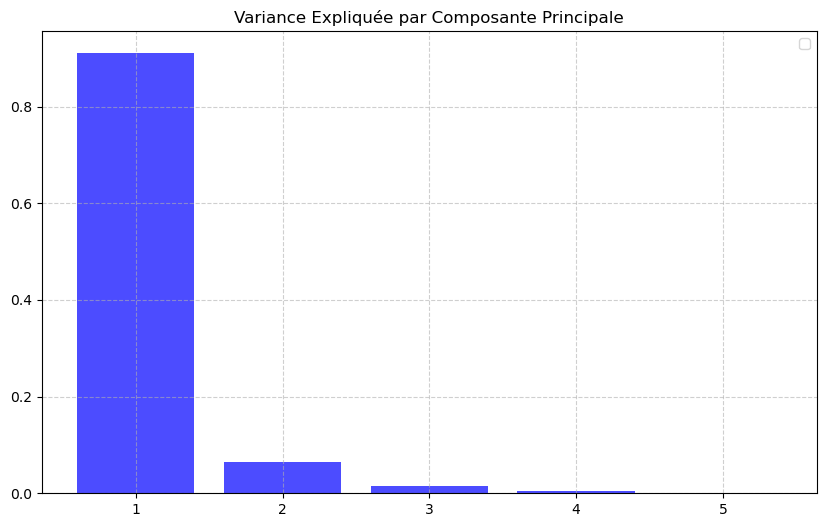

In [30]:
# Explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Plot individual explained variance ratios
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, alpha=0.7, color='b')
plt.title('Variance Expliquée par Composante Principale')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

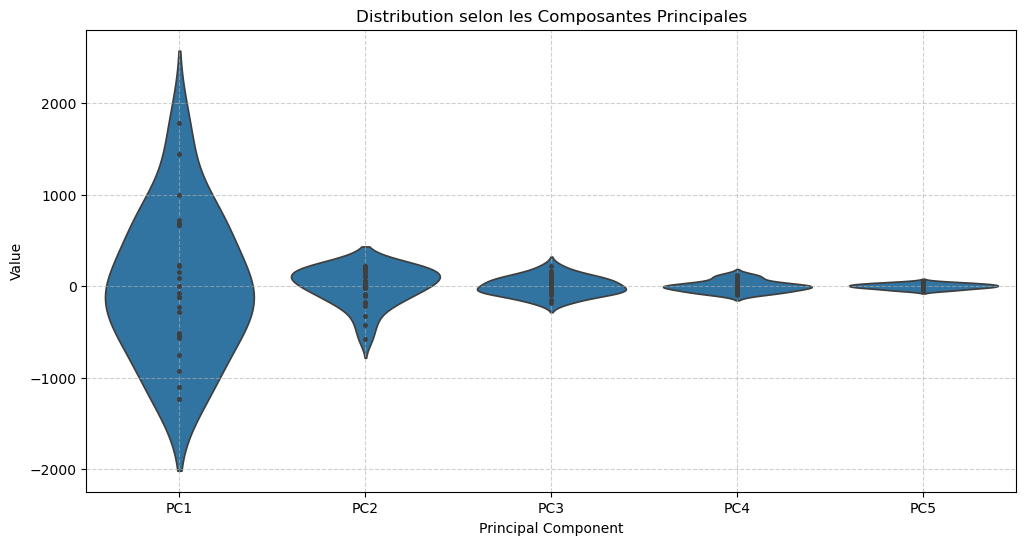

In [31]:
# Prepare data for Seaborn
pc_df = pd.DataFrame(components[:, :5], columns=[f'PC{i+1}' for i in range(5)])
pc_df_melted = pc_df.melt(var_name='Principal Component', value_name='Value')

# Seaborn Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=pc_df_melted, x='Principal Component', y='Value', inner="point", scale="width")
plt.title('Distribution selon les Composantes Principales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

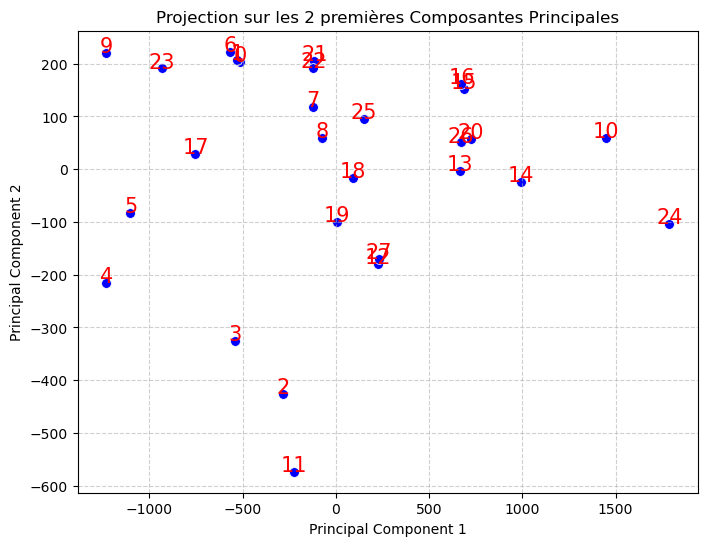

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], s=50, color="b")

# Add labels for each point
for i, (x, y) in enumerate(zip(components[:, 0], components[:, 1])):
    plt.text(x + 1, y + 1, str(i), fontsize=15, color="red", ha="center")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projection sur les 2 premières Composantes Principales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [33]:
"""
print(shape_names[0])
print(shape_names[7])
print(shape_names[9])
print(shape_names[15])
print(shape_names[21])
"""
print(shape_names[24])
print(shape_names[9])
print(shape_names[4])
print(shape_names[5])
#"""

RF_FULGUR_094_12359_label_4_local
RF_FULGUR_029_15058_left_label_4_local
RF_FULGUR_008_181477_label_4_local
RF_FULGUR_009_25705_label_4_local


In [34]:
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
print(eigenvalues[0])

584336.0656887677


### Generate Files

In [35]:
pca = PCA()
pca.fit(particles_flat)

eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
print(eigenvalues)

[5.84336066e+05 4.20463035e+04 9.91049100e+03 3.61615908e+03
 7.82050633e+02 4.83749502e+02 2.78187096e+02 1.97150244e+02
 7.75165167e+01 4.26657085e+01 3.94174664e+01 2.71805565e+01
 1.61366497e+01 1.50850517e+01 9.92949866e+00 9.07822825e+00
 6.58736168e+00 5.30128789e+00 4.44330602e+00 3.65535222e+00
 3.01465963e+00 2.51762766e+00 2.10066848e+00 1.58200525e+00
 1.33909689e+00 1.14600521e+00 7.94243478e-01 4.71185252e-26]


In [36]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Save eigenvalues
with open(os.path.join(OUTPUT_DIR, 'eigenvalues.eval'), 'w') as f:
    for i, eigenvalue in enumerate(eigenvalues):
        f.write(f'{eigenvalue}\n')

# Save eigenvectors
eigenvectors_reshaped = eigenvectors.reshape(eigenvectors.shape[0], -1, 3)
for i, eigenvector in enumerate(eigenvectors_reshaped):
    filename = os.path.join(OUTPUT_DIR, f'eigenvector_{i+1}.eig')
    np.savetxt(filename, eigenvector, fmt='%f')